This notebook performs a statistical analysis on the learning rates between two groups of mice, and generates publication-ready figures. It is split in 3 parts:
1. Load requirements and basic exploration of the data
2. Model fitting of individual mice, comparison of parameters and import of lesion data for each mouse from image analysis to remove individual mice from the study
3. Statistical analysis between the groups to conclude differences and points of divergence in learning

TODO:
- CurrentPastPerformance100 has some NaNs where it is not supposed to in theory. Re-check how this is calculated

In [77]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
from scipy import stats
import scipy.optimize as opt
import random


#warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Dataset name
DS_name = '6OHDA_Apr2020'

'''
This dataset has already been pre-processed, eliminating initial trials for example
'''

'\nThis dataset has already been pre-processed, eliminating initial trials for example\n'

In [3]:
# path to the dataset
data_directory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/' + DS_name + '_Analysis/'
# dataframe name
df_name = DS_name + '_dataframe.pkl'

# Read the dataframe
df_to_plot = pd.read_pickle(data_directory + df_name)

In [4]:
# Select only the auditory for now
df_to_plot = df_to_plot[df_to_plot.Protocol == 'Auditory']

In [5]:
# Specific for the 6OHDA data:
# remove some animals from the first cohort
ans_to_remove = ['C04', 'C05', 'C06', 'N06']
df_to_plot = df_to_plot[~df_to_plot.AnimalID.isin(ans_to_remove)]

In [6]:
df_to_plot.columns

Index(['AnimalID', 'CenterPortDuration', 'Contingency',
       'CumulativePerformance', 'ExperimentalGroup', 'FirstPoke',
       'FirstPokeCorrect', 'FullSessionTime', 'Muscimol', 'OptoStim',
       'Outcomes', 'PreviousChoice', 'Protocol', 'ResponseTime',
       'RewardAmount', 'RewardChange', 'RewardChangeBlock', 'RightBias',
       'SessionTime', 'Stimulation', 'SwitchSide', 'TrialEvents',
       'TrialHighPerc', 'TrialIndex', 'TrialSequence', 'TrialSide',
       'TrialStartTimestamp', 'TrialStates', 'SessionID',
       'CumulativeTrialNumber', 'CumulativeTrialNumberByProtocol',
       'CurrentPastPerformance20', 'CurrentPastPerformance100',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime',
       'TrialsSpeed', 'PrevTrialSuccess'],
      dtype='object')

In [7]:
# number of trials per mouse in the dataset
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).size()

AnimalID  ExperimentalGroup  Protocol
C01       CortexBuffer       Auditory    4879
C02       CortexBuffer       Auditory    4901
C03       CortexBuffer       Auditory    4879
PV01      6OHDAtail          Auditory    4868
PV02      6OHDAtail          Auditory    4912
PV03      6OHDAtail          Auditory    4890
PV04      6OHDAtail          Auditory    4890
PV05      6OHDAtail          Auditory    4901
PV06      6OHDAtail          Auditory    4879
PV08      6OHDAtail          Auditory    4879
SomFlp04  CortexBuffer       Auditory    4810
SomFlp06  CortexBuffer       Auditory    4857
SomFlp07  6OHDAtail          Auditory    4868
SomFlp08  6OHDAtail          Auditory    4890
SomFlp09  6OHDAtail          Auditory    4890
dtype: int64

In [8]:
# maximum number of trials performed per mouse in the dataset:
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumberByProtocol']

AnimalID  ExperimentalGroup  Protocol
C01       CortexBuffer       Auditory    5000.0
C02       CortexBuffer       Auditory    5000.0
C03       CortexBuffer       Auditory    5000.0
PV01      6OHDAtail          Auditory    5000.0
PV02      6OHDAtail          Auditory    5000.0
PV03      6OHDAtail          Auditory    5000.0
PV04      6OHDAtail          Auditory    5000.0
PV05      6OHDAtail          Auditory    5000.0
PV06      6OHDAtail          Auditory    5000.0
PV08      6OHDAtail          Auditory    5000.0
SomFlp04  CortexBuffer       Auditory    4953.0
SomFlp06  CortexBuffer       Auditory    5000.0
SomFlp07  6OHDAtail          Auditory    5000.0
SomFlp08  6OHDAtail          Auditory    5000.0
SomFlp09  6OHDAtail          Auditory    5000.0
Name: CumulativeTrialNumberByProtocol, dtype: float64

In [9]:
# bin trials every 200
df_to_plot["TrialIndexBinned200"] = (df_to_plot.CumulativeTrialNumberByProtocol // 200) * 200

In [10]:
# bin trials every 30
df_to_plot["TrialIndexBinned30"] = (df_to_plot.CumulativeTrialNumberByProtocol // 30) * 30

#### Make figure-ready plots

Progress: [####################] 100.0%


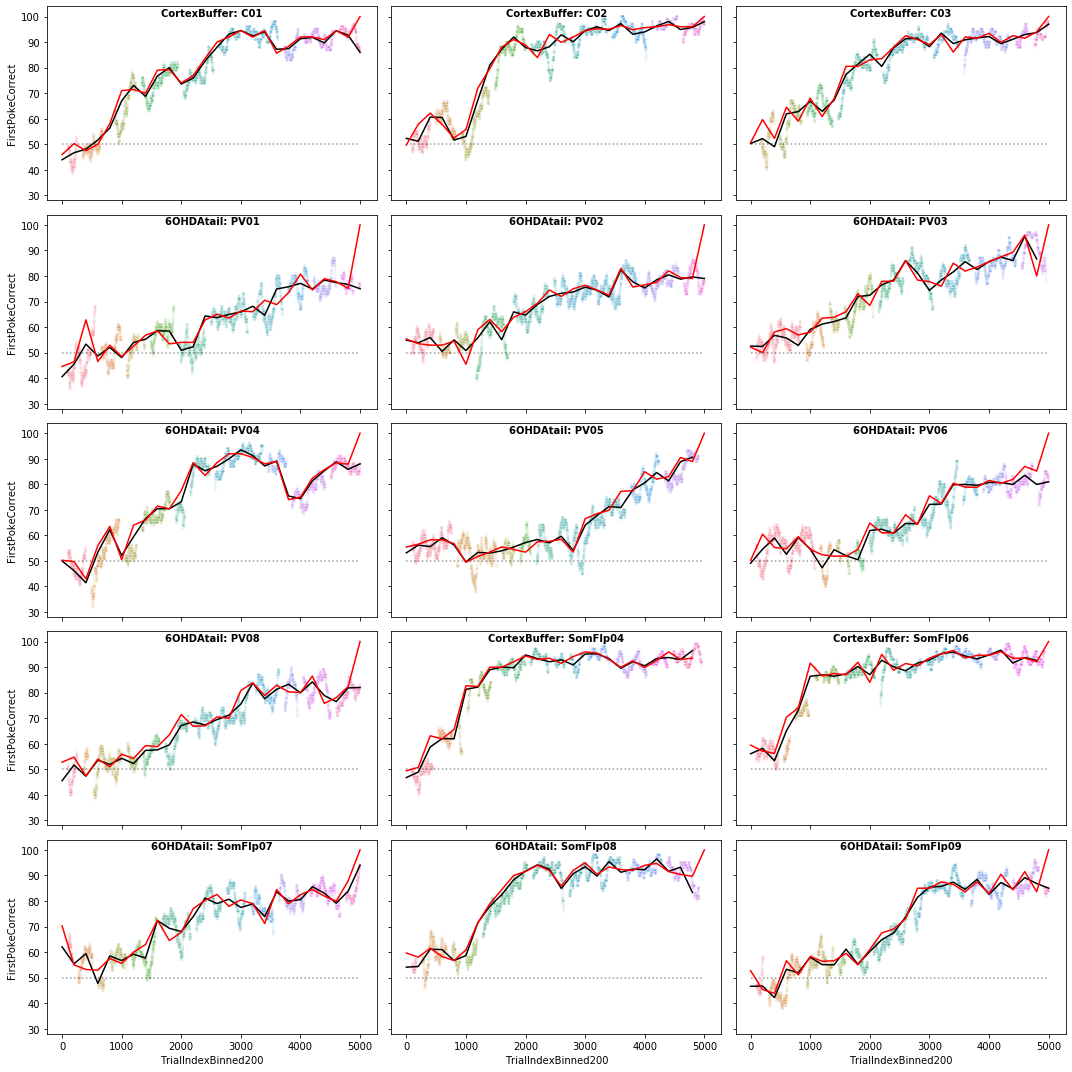

In [393]:
var_to_plot = 'CurrentPastPerformance100'
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    
    # plot here
    sns.scatterplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                x="CumulativeTrialNumberByProtocol",
                y=var_to_plot,
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # plot a line for binned trials
    sns.lineplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                 x="TrialIndexBinned200",
                 y=var_to_plot,
                 color='k',
                 ci=None,
                 ax=ax)
    
    # plot a line for binned trials
    sns.lineplot(x=df_to_plot[df_to_plot.AnimalID == animal]["TrialIndexBinned200"],
                 y=100 * df_to_plot[df_to_plot.AnimalID == animal]["FirstPokeCorrect"],
                 color='r',
                 ci=None,
                 ax=ax)
    
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
update_progress(1)
plt.savefig(data_directory + var_to_plot + '_individual_animals.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [394]:
# Sanity check on the data
animal = 'PV06'
testdf = df_to_plot[df_to_plot.AnimalID == animal]

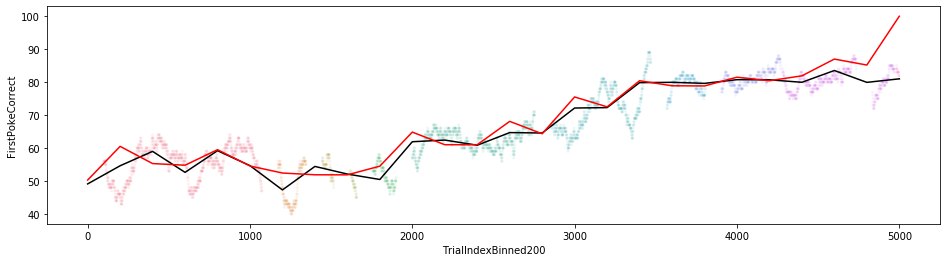

In [397]:
# plot here
plt.figure(figsize=(16, 4))
sns.scatterplot(data=testdf,
            x="CumulativeTrialNumberByProtocol",
            y=var_to_plot,
            marker='.',
            hue='SessionID',
            alpha=.1)

# plot a line for binned trials
sns.lineplot(data=testdf,
             x="TrialIndexBinned200",
             y=var_to_plot,
             color='k',
             ci=None)

# plot a line for binned trials
sns.lineplot(x=testdf["TrialIndexBinned200"],
             y=100 * testdf["FirstPokeCorrect"],
             color='r',
             ci=None)
plt.gca().get_legend().remove()

In [405]:
np.mean(testdf[testdf.TrialIndexBinned200 == 200].FirstPokeCorrect)

0.605

In [410]:
np.mean(testdf[testdf.TrialIndexBinned200 == 200][var_to_plot])

54.61

#### Fit a curve to every mouse and calculate stages and learning rates

In [13]:
#calculate the maximum performance for every mouse based on the trials binned every 200
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200','Protocol']).median().reset_index()
mouse_max_perf = df_bin200tr.groupby('AnimalID').max().reset_index()[['AnimalID', 'CurrentPastPerformance100']]

Progress: [###################-] 93.3%


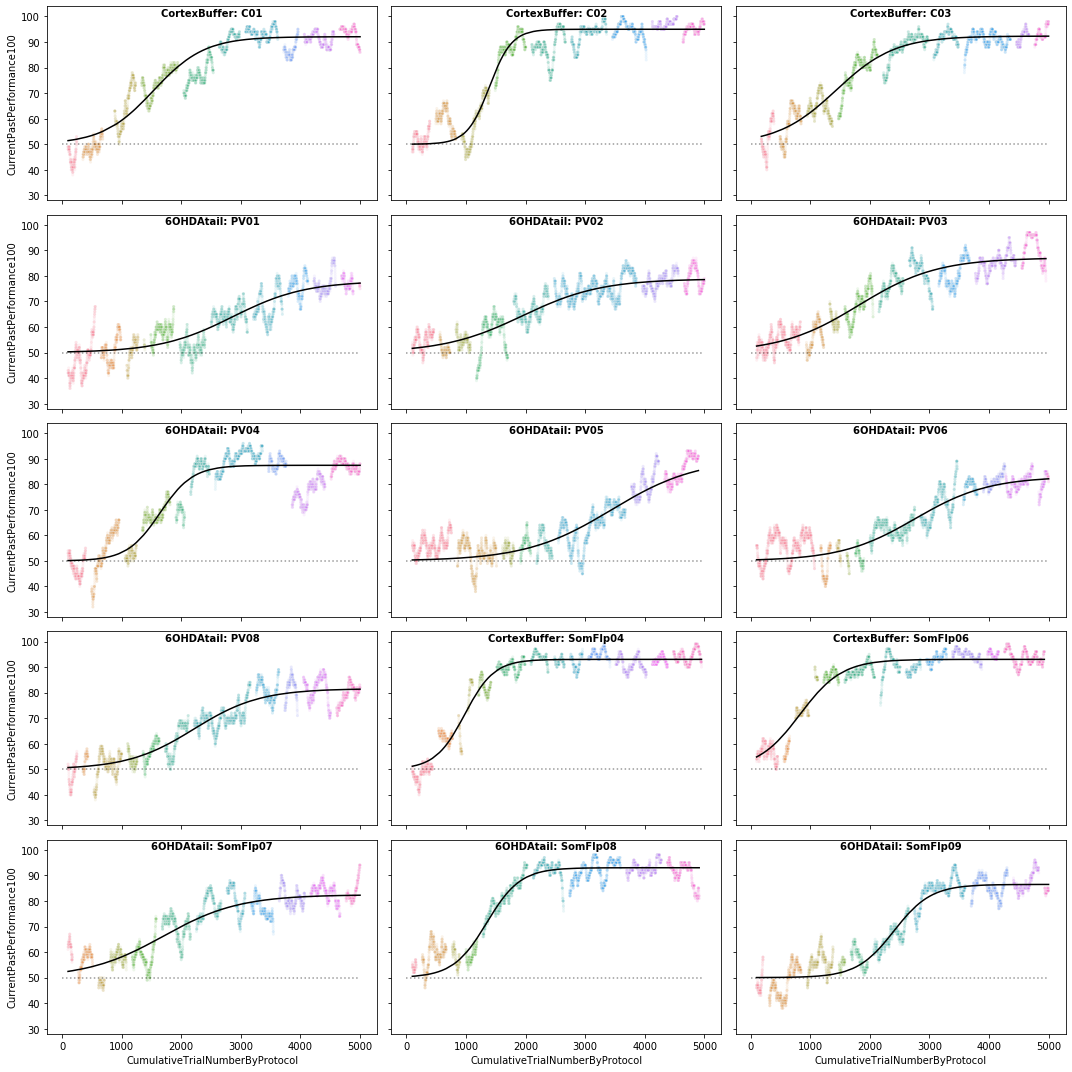

In [14]:
def sigmoid_func(x, perf_end, slope, bias): 
    return (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5 


ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
# create a diccionary to store the results, and lists to rescale the data
fit_dir = {}
xmeans_list = []
xsd_list = []

fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # plot here
    sns.scatterplot(data=df,
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # calculate and plot the fitting
    xdata = np.array(df.CumulativeTrialNumberByProtocol)
    ydata = np.array(df.CurrentPastPerformance100)
    
    # scale the data
    xdatasc = (xdata - xdata.mean()) / xdata.std()
    ydatasc = ydata / 100
    
    # limit to the maximum performance for this mouse:
    mp = mouse_max_perf[mouse_max_perf.AnimalID==animal].CurrentPastPerformance100.iloc[0] / 100

    cost_func = lambda x: np.mean(np.abs(sigmoid_func(xdatasc, x[0], x[1], x[2]) - ydatasc))
    res = opt.minimize(cost_func, [1, 0, 0], bounds=((0.5, mp), (0., 10.), (None,None)))
    
    # predict the data and rescale it back
    ypredscb = 100 * sigmoid_func(xdatasc, *res.x)

    sns.lineplot(x=xdata,
                 y=ypredscb,
                 color='k',
                 ci=None,
                 ax=ax)
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
    #update dicctionary and lists
    fit_dir[animal] = res
    xmeans_list.append(xdata.mean())
    xsd_list.append(xdata.std())
    
plt.show()

In [15]:
for key, value in fit_dir.items():
    print(key,  '  ', value.x)

C01    [ 0.92086849  3.27790058 -0.76667798]
C02    [ 0.95000045  7.52657559 -0.83072467]
C03    [ 0.92330201  2.77562132 -0.84402498]
PV01    [0.78       2.29136147 0.24779116]
PV02    [ 0.788498    2.11315675 -0.47571014]
PV03    [ 0.87077763  2.18982105 -0.5026796 ]
PV04    [ 0.87423877  5.22393763 -0.66601401]
PV05    [0.9        1.98164991 0.64922732]
PV06    [0.83       2.34595107 0.14719633]
PV08    [ 0.8154894   2.51962957 -0.29580117]
SomFlp04    [ 0.93009429  5.80461918 -1.13948451]
SomFlp06    [ 0.93011264  4.03503822 -1.25323015]
SomFlp07    [ 0.82426246  2.19109731 -0.6730615 ]
SomFlp08    [ 0.93000266  4.84466477 -0.92028747]
SomFlp09    [ 0.86472667  4.48039555 -0.12443441]


In [16]:
# convert to dataframe
fit_df = pd.DataFrame({
    'AnimalID': list(fit_dir.keys()),
    'maximum_performance': [v.x[0] for k, v in fit_dir.items()],
    'slope': [v.x[1] for k, v in fit_dir.items()],
    'bias': [v.x[2] for k, v in fit_dir.items()]
})
# get the Experimental procedure
fit_df['ExperimentalGroup'] = fit_df['AnimalID'].apply(
        lambda x: df_to_plot[df_to_plot.AnimalID==x].ExperimentalGroup.unique()[0]
    )
# rescale back the coefficients
fit_df.maximum_performance = fit_df.maximum_performance * 100
fit_df.slope = fit_df.slope / np.array(xsd_list)
fit_df.bias = fit_df.bias * np.array(xsd_list) + np.array(xmeans_list)

In [17]:
fit_df

,AnimalID,maximum_performance,slope,bias,ExperimentalGroup
0,C01,92.086849,0.002335,1535.856696,CortexBuffer
1,C02,95.000045,0.005319,1393.325063,CortexBuffer
2,C03,92.330201,0.002026,1435.046183,CortexBuffer
3,PV01,78.000000,0.001638,2860.341218,6OHDAtail
4,PV02,78.849800,0.001514,1949.908581,6OHDAtail
5,PV03,87.077763,0.001519,1814.635627,6OHDAtail
6,PV04,87.423877,0.003629,1641.151969,6OHDAtail
7,PV05,90.000000,0.001391,3440.405944,6OHDAtail
8,PV06,83.000000,0.001615,2758.479994,6OHDAtail
9,PV08,81.548940,0.001805,2214.355161,6OHDAtail


#### explore another way of calculating the learning rate (e.g. maximum of the derivative) and the bias (e.g. learning period extracted from percentages of the sigmoid)

In [18]:
# sigmoid function scaled
def sigmoid_func_sc(x, perf_end, slope, bias): 
    return (perf_end - 50) / (1 + np.exp(-slope * (x - bias))) + 50

In [19]:
# derivative function
def der_sig(x, perf_end, slope, bias):
    return (perf_end - 50) * slope * np.exp(- slope * (x - bias)) / (1 + np.exp(- slope * (x - bias)))**2

In [20]:
# find the steepest point of each slope (max of der)
der_max_dir = {}
for animal in ans_list:
    m_point = opt.fmin(lambda x: -der_sig(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                               fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                               fit_df[fit_df.AnimalID==animal].bias.iloc[0]]), 0, full_output=True)
    
    der_max_dir[animal] = (m_point[0][0], -m_point[1])

Optimization terminated successfully.
         Current function value: -0.024573
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.059836
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.021436
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.011467
         Iterations: 48
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -0.010917
         Iterations: 47
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.014083
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.033950
         Iterations: 46
         Function evaluations: 92
Optimization terminated suc

In [21]:
der_max_dir

{'C01': (1535.856687500002, 0.02457304212136555),
 'C02': (1393.3250625000016, 0.0598358050599385),
 'C03': (1435.0461875000017, 0.02143603603356482),
 'PV01': (2860.341250000004, 0.011467101382713498),
 'PV02': (1949.9085625000027, 0.010917385820028463),
 'PV03': (1814.6356250000022, 0.014083477188559103),
 'PV04': (1641.1520000000019, 0.03395045086486938),
 'PV05': (3440.4059375000047, 0.013911753020729665),
 'PV06': (2758.480000000003, 0.013324801542361814),
 'PV08': (2214.355187500003, 0.014236907340503084),
 'SomFlp04': (979.8273125000012, 0.04352432418525172),
 'SomFlp06': (829.4663125000006, 0.030521115509709148),
 'SomFlp07': (1697.6685000000025, 0.012756844489343833),
 'SomFlp08': (1350.0392500000016, 0.03803082574015238),
 'SomFlp09': (2403.9987500000025, 0.029299138057469237)}

#### the point of the maxium in the x axis the same as the bias, but the derivative value at that time is giving me the biggest slope

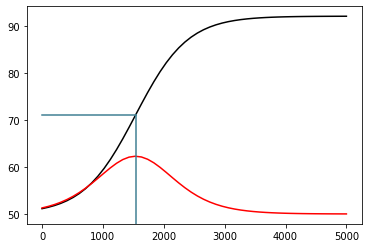

In [22]:
# sanity check
x = np.linspace(0,5000)
animal='C01'
sns.lineplot(x=x,
                 y=sigmoid_func_sc(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='k',
                 ci=None)

sns.lineplot(x=x,
                 y=50 + 500 * der_sig(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='r',
                 ci=None)

ymin, ymax = plt.gca().get_ybound()
perc_max_slope = sigmoid_func_sc(der_max_dir[animal][0],
                                 *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                   fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                   fit_df[fit_df.AnimalID==animal].bias.iloc[0]])


plt.axvline(der_max_dir[animal][0], 0, (perc_max_slope - ymin) / (ymax - ymin))

plt.plot([0, der_max_dir[animal][0]], [perc_max_slope,perc_max_slope])

plt.show()

Progress: [###################-] 93.3%


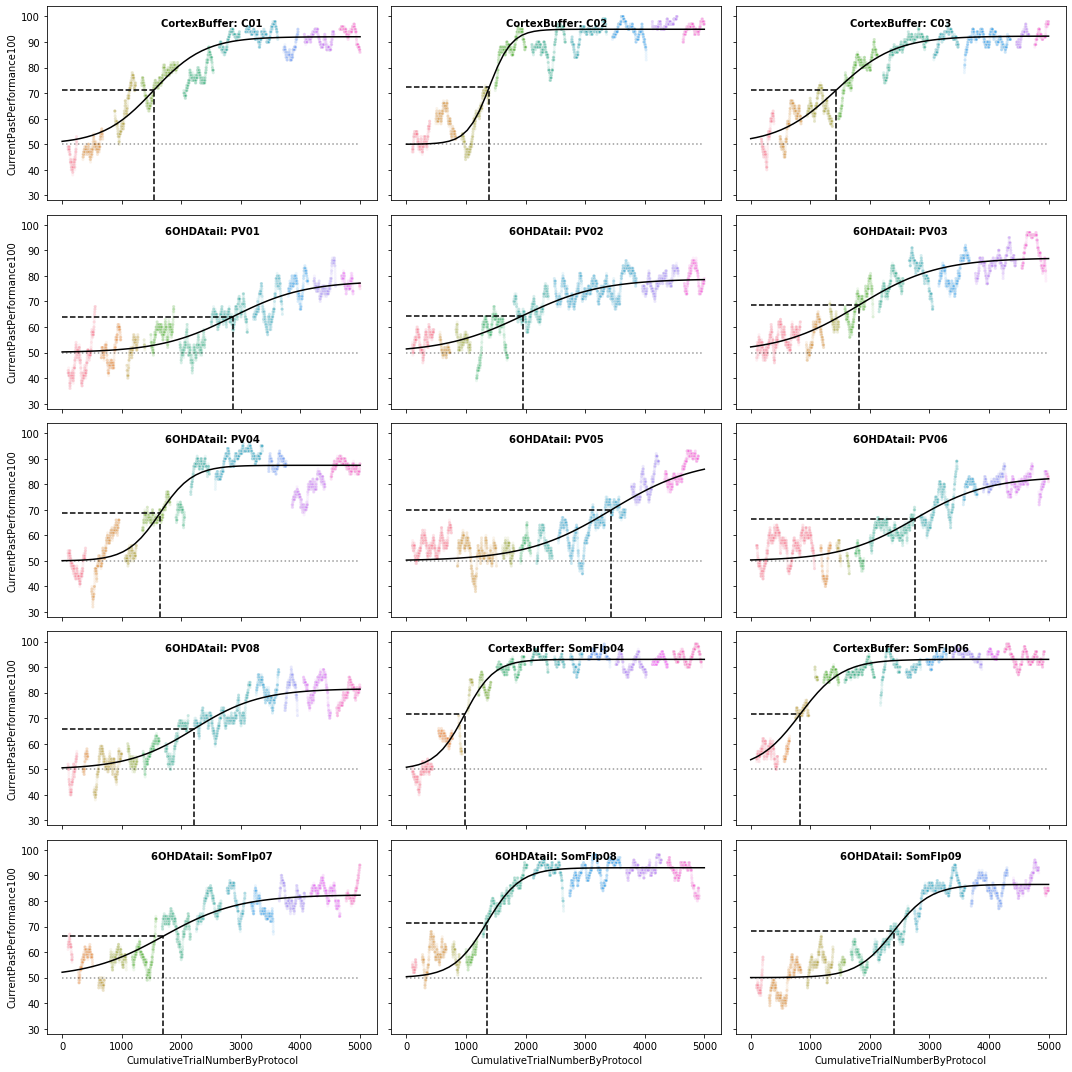

In [23]:
# plot the curves again pointing to the maximum
# sanity check to see that these scaled values recreate the curves

x = np.linspace(1,5000)

fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # plot here
    sns.scatterplot(data=df,
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    sns.lineplot(x=x,
                 y=sigmoid_func_sc(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='k',
                 ci=None,
                 ax=ax)
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.9, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)


# point to the maximum slope
ymin, ymax = plt.gca().get_ybound()
for counter, animal in enumerate(ans_list):
    ax = axs[counter] 
    perc_max_slope = sigmoid_func_sc(der_max_dir[animal][0],
                                     *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                       fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                       fit_df[fit_df.AnimalID==animal].bias.iloc[0]])
    ax.axvline(der_max_dir[animal][0], 0, (perc_max_slope - ymin) / (ymax - ymin), linestyle='--', color='k')
    ax.plot([0, der_max_dir[animal][0]], [perc_max_slope,perc_max_slope], 'k--')
    
    
plt.show()

In [24]:
# add the maximum value of the derivative to the fit_df dataframe
for key, value in der_max_dir.items():
    fit_df.loc[fit_df.index[fit_df['AnimalID'] == key].tolist()[0], 'max_of_der'] = value[1]

In [25]:
fit_df

,AnimalID,maximum_performance,slope,bias,ExperimentalGroup,max_of_der
0,C01,92.086849,0.002335,1535.856696,CortexBuffer,0.024573
1,C02,95.000045,0.005319,1393.325063,CortexBuffer,0.059836
2,C03,92.330201,0.002026,1435.046183,CortexBuffer,0.021436
3,PV01,78.000000,0.001638,2860.341218,6OHDAtail,0.011467
4,PV02,78.849800,0.001514,1949.908581,6OHDAtail,0.010917
5,PV03,87.077763,0.001519,1814.635627,6OHDAtail,0.014083
6,PV04,87.423877,0.003629,1641.151969,6OHDAtail,0.033950
7,PV05,90.000000,0.001391,3440.405944,6OHDAtail,0.013912
8,PV06,83.000000,0.001615,2758.479994,6OHDAtail,0.013325
9,PV08,81.548940,0.001805,2214.355161,6OHDAtail,0.014237


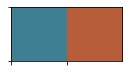

In [26]:
# set a color palette https://xkcd.com/color/rgb/
'''
hmv_palette = ['#380282', '#c04e01']
sns.set_palette(hmv_palette)
sns.palplot(sns.color_palette())
'''
LSpalette = [(0.24715576, 0.49918708, 0.57655991), (0.72162039, 0.3669119 , 0.22526315)]
sns.set_palette(LSpalette)
sns.palplot(LSpalette)

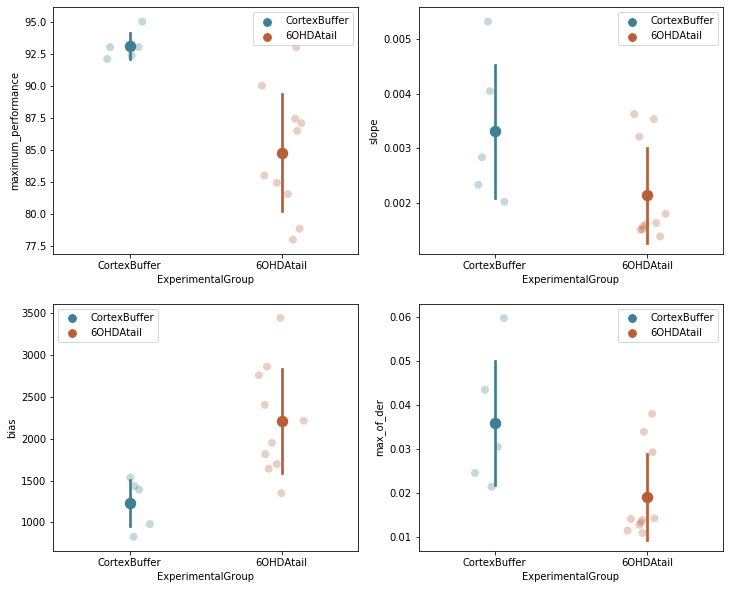

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=False, figsize=(12,10))
axs = axs.ravel()
for i, var in enumerate(['maximum_performance', 'slope', 'bias', 'max_of_der']):
    sns.pointplot(data=fit_df,
                x='ExperimentalGroup',
                y=var,
                hue='ExperimentalGroup',
                dodge=False, join=False,
                markers="o", scale=1.3, ci='sd',
                ax=axs[i])
    
    sns.stripplot(data=fit_df,
                x='ExperimentalGroup',
                y=var,
                hue='ExperimentalGroup',
                dodge=False, jitter=.15,
                alpha=.3, zorder=1, size=8,
                ax=axs[i])

for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
#ax2.legend(bbox_to_anchor=(1.23, 1), loc=0, borderaxespad=0.)
#axs[1].set_ylim(0.8 * np.min(fit_df.slope), 1.1 * np.max(fit_df.slope))
#axs[1].get_legend().remove()

In [28]:
for var in ['maximum_performance', 'slope', 'bias', 'max_of_der']:
    kt = stats.kruskal(fit_df[fit_df.ExperimentalGroup=='CortexBuffer'][var].dropna(),
                  fit_df[fit_df.ExperimentalGroup=='6OHDAtail'][var].dropna())
    print(var + ':\t\tpvalue: ' + str(kt.pvalue) )

maximum_performance:		pvalue: 0.004848762721678959
slope:		pvalue: 0.0500435212487048
bias:		pvalue: 0.007050729110422718
max_of_der:		pvalue: 0.03733641592066285


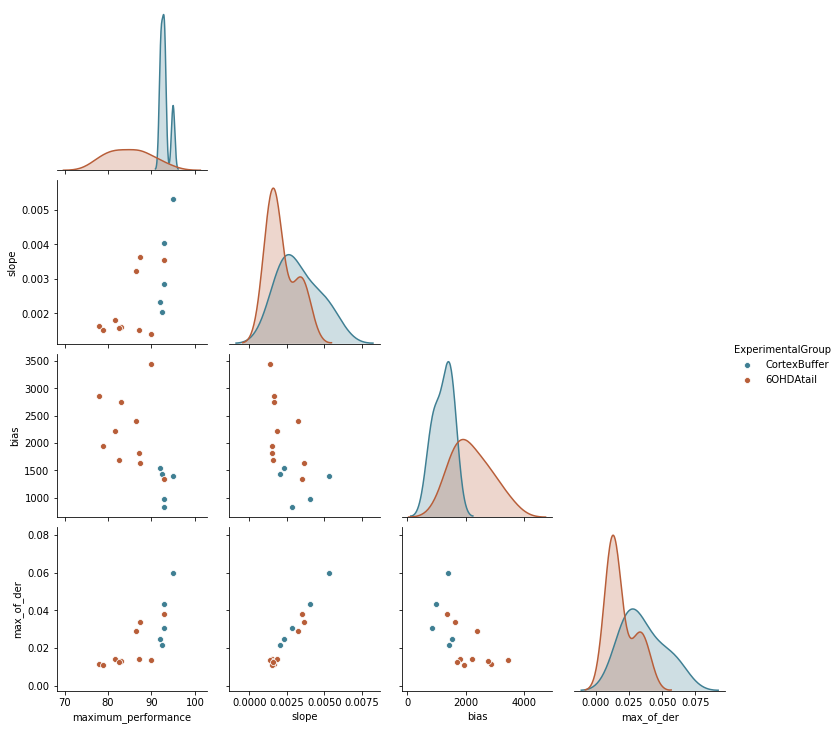

In [29]:
# Basic correlogram
g = sns.pairplot(fit_df, hue='ExperimentalGroup', corner=True)#, kind='reg')
g.axes[1,1].set_ylim(0.8 * np.min(fit_df.slope), 1.1 * np.max(fit_df.slope))
plt.show()


In [30]:
# merge this with the imaging data
image_analysis_results_file = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Histology_of_tail_lesions/6OHDA/summary_df_LS_Apr2020.csv'

In [31]:
# read csv file
iar = pd.read_csv(image_analysis_results_file)

In [32]:
iar

,Unnamed: 0,median_performance_reached_in_last_ntrials,performance_cf_control,n trials to criterion,max performance reached,mouse id,lesion condition,ratio posterior/anterior
0,0,78.174603,90.909091,4170,90.909091,PV01,OHDA,0.244704
1,1,76.684313,84.000000,4467,84.000000,PV02,OHDA,0.240482
2,2,90.702714,92.920354,2587,92.920354,PV03,OHDA,0.224340
3,3,86.832401,89.740699,2197,89.740699,PV04,OHDA,0.248894
4,4,88.512420,94.871795,2948,94.871795,PV05,OHDA,0.265733
5,5,81.028968,83.118741,4210,83.118741,PV06,OHDA,0.320209
6,6,76.641109,90.909091,3185,90.909091,PV08,OHDA,0.199283
7,7,95.073408,100.000000,1501,100.000000,SomFlp04,control,0.464136
8,8,93.823477,100.000000,1521,100.000000,SomFlp06,control,0.484376
9,9,82.378088,90.000000,2689,90.000000,SomFlp07,OHDA,0.170407


In [33]:
# add these columns to the df for correlation comparison and subselect some
merged_df = pd.merge(left=fit_df, right=iar, how='left', left_on='AnimalID', right_on='mouse id')[
    ['AnimalID',
     'maximum_performance',
     'bias',
     'ExperimentalGroup',
     'max_of_der',
     'median_performance_reached_in_last_ntrials',
     'n trials to criterion',
     'max performance reached',
     'ratio posterior/anterior']
]

/home/hmvergara/anaconda3/envs/behav/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


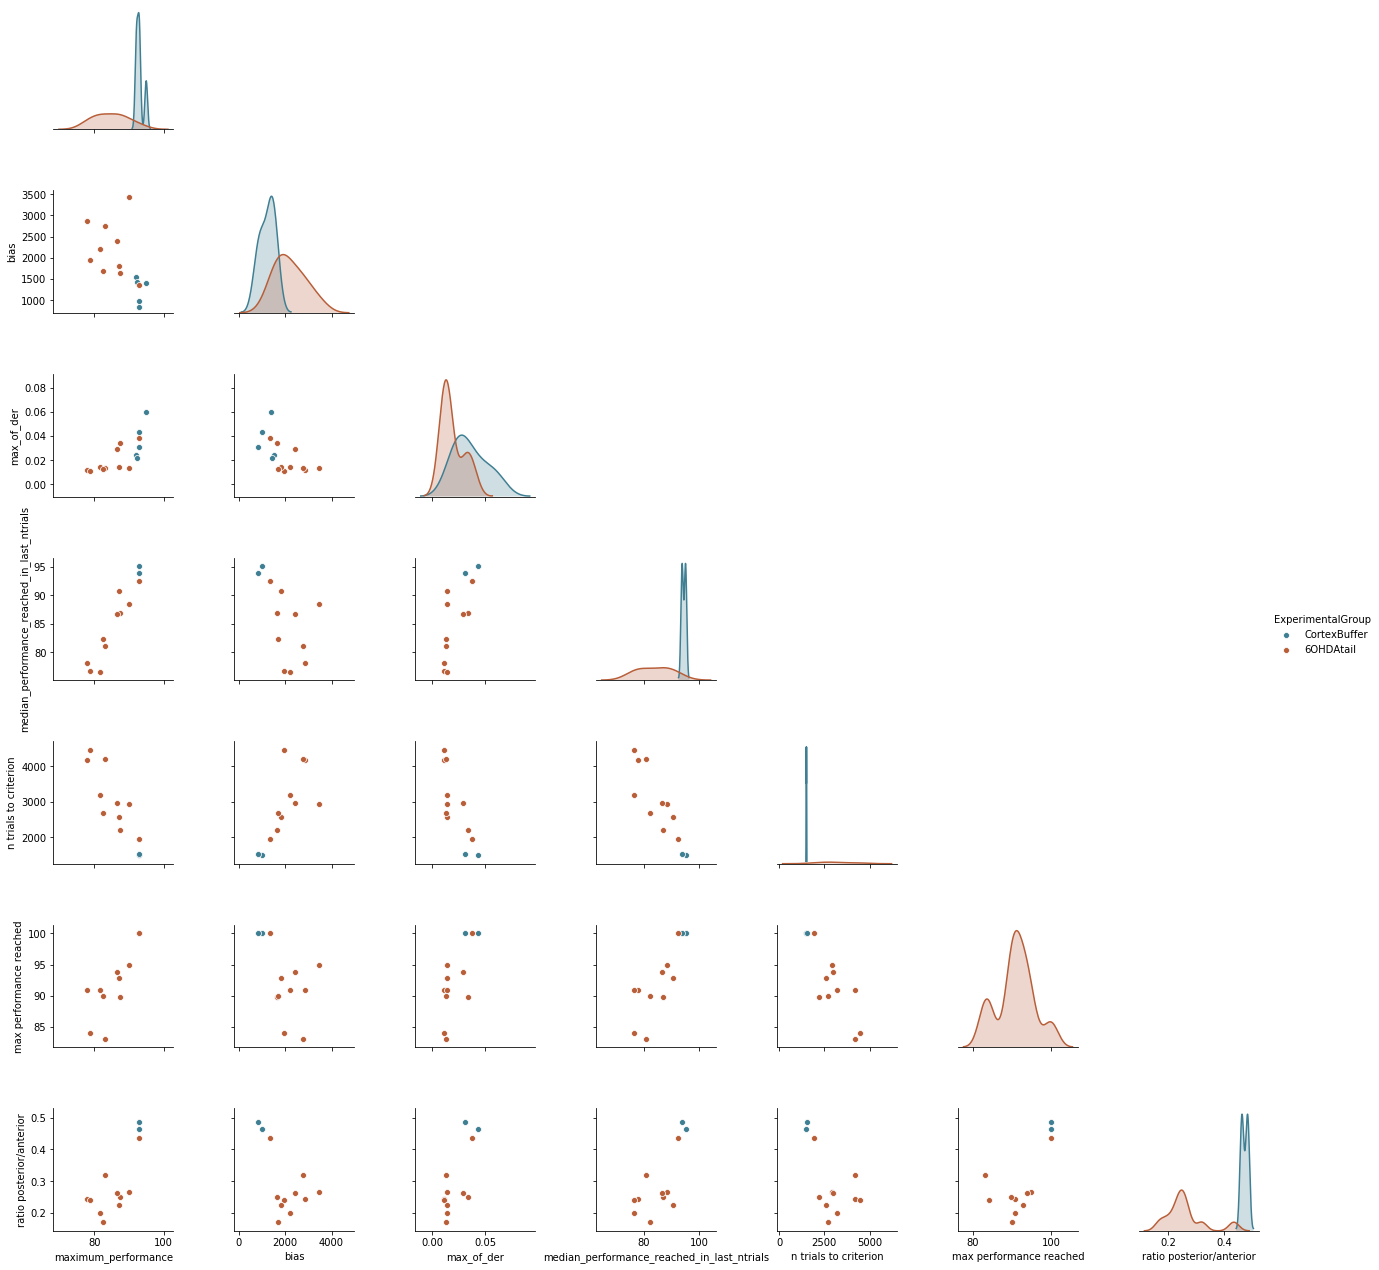

In [34]:
# Basic correlogram
g = sns.pairplot(merged_df, hue='ExperimentalGroup', corner=True)#, diag_kind=None)#, kind='reg')
#g.axes[1,1].set_ylim(0.8 * np.min(fit_df.slope), 1.1 * np.max(fit_df.slope))
plt.show()

/home/hmvergara/anaconda3/envs/behav/lib/python3.7/site-packages/seaborn/axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


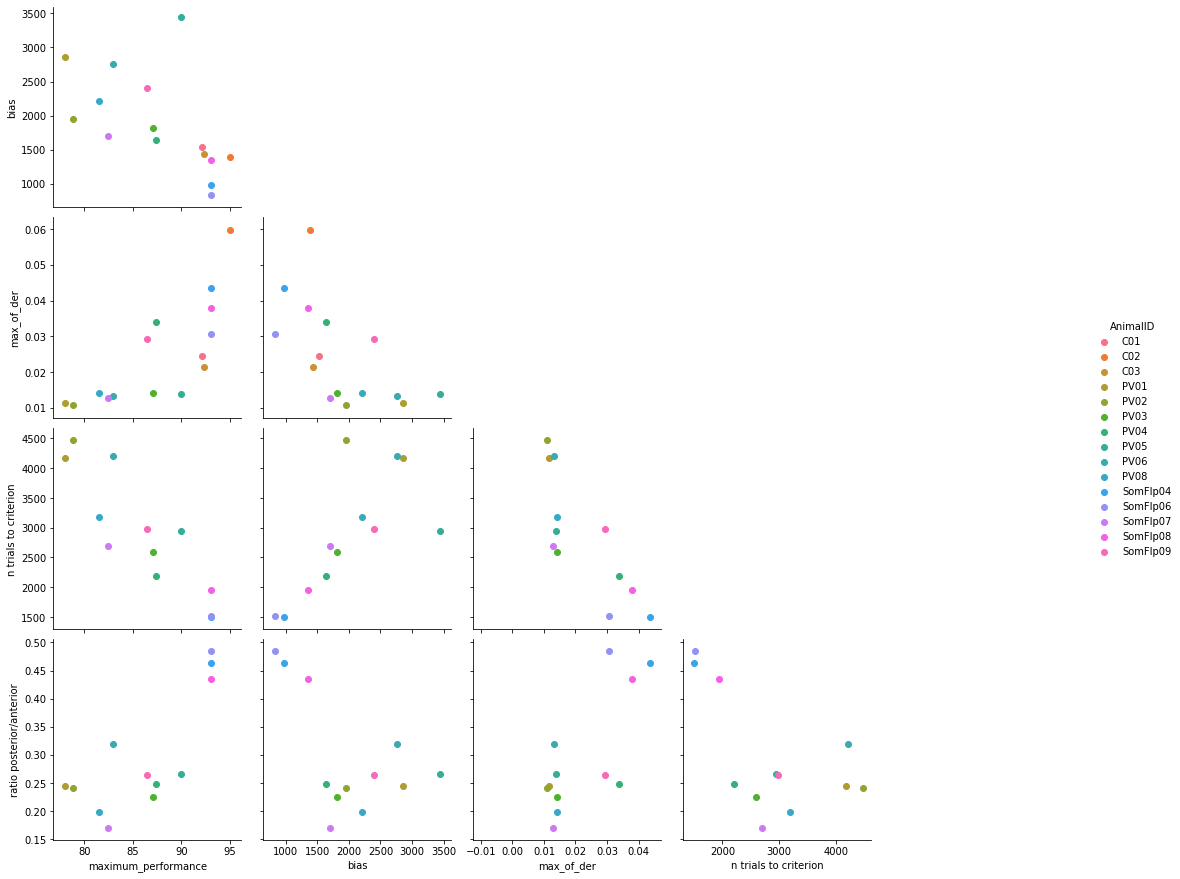

In [35]:
# Create an instance of the PairGrid class.
grid = sns.PairGrid(data= merged_df,
                    vars = ['maximum_performance',
                             'bias',
                             'max_of_der',
                             'n trials to criterion',
                             'ratio posterior/anterior'],
                    size = 3,
                    hue = 'AnimalID')
# Map a scatter plot to the upper triangle
grid = grid.map_lower(plt.scatter)
for i, j in zip(*np.triu_indices_from(grid.axes, 0)):
    grid.axes[i, j].set_visible(False)
#grid.axes[2, 2].set_xlim(0.8 * np.min(merged_df.max_of_der), 1.1 * np.max(merged_df.max_of_der))
#grid.axes[2, 3].set_xlim(0.8 * np.min(merged_df.max_of_der), 1.1 * np.max(merged_df.max_of_der))
grid.add_legend()

In [36]:
# Select animals to remove from the study based on this
ans_to_remove = ['SomFlp08']
df_sel = df_to_plot[~df_to_plot.AnimalID.isin(ans_to_remove)]

### calculate the statistical differences of performances between groups at different trial indexes

In [37]:
# groupby so each animal has a mean of the performance in each bin
df_bintr = df_sel.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned30','Protocol']).median().reset_index()

In [38]:
df_bintr[df_bintr.AnimalID=='C01']

,AnimalID,ExperimentalGroup,TrialIndexBinned30,Protocol,CenterPortDuration,Contingency,CumulativePerformance,FirstPoke,FirstPokeCorrect,OptoStim,...,CumulativeTrialNumber,CumulativeTrialNumberByProtocol,CurrentPastPerformance20,CurrentPastPerformance100,NoOfCenterPokes,MiddleWaitTime,TrialInitiationTime,TrialsSpeed,PrevTrialSuccess,TrialIndexBinned200
0,C01,CortexBuffer,0.0,Auditory,0.1,1.0,58.359133,2.0,0.0,0.0,...,3340.5,20.5,40.0,NaN,2.0,0.14150,2.74870,3.423923,0.0,0.0
1,C01,CortexBuffer,30.0,Auditory,0.1,1.0,57.142857,2.0,1.0,0.0,...,3364.5,44.5,55.0,NaN,2.0,0.14200,2.25420,9.209508,1.0,0.0
2,C01,CortexBuffer,60.0,Auditory,0.1,1.0,53.378995,1.0,0.0,0.0,...,3394.5,74.5,45.0,NaN,2.0,0.11590,2.37010,9.321035,0.0,0.0
3,C01,CortexBuffer,90.0,Auditory,0.1,1.0,51.649148,1.0,0.0,0.0,...,3424.5,104.5,45.0,48.0,3.0,0.11510,2.23120,10.607701,0.0,0.0
4,C01,CortexBuffer,120.0,Auditory,0.1,1.0,48.319423,2.0,0.0,0.0,...,3454.5,134.5,30.0,46.0,3.0,0.12645,2.29930,9.670172,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,C01,CortexBuffer,4860.0,Auditory,0.1,1.0,95.447142,1.0,1.0,0.0,...,8194.5,4874.5,100.0,96.0,2.0,0.12725,0.77510,26.886117,1.0,4800.0
163,C01,CortexBuffer,4890.0,Auditory,0.1,1.0,95.405809,1.0,1.0,0.0,...,8224.5,4904.5,95.0,96.0,3.0,0.12675,0.71830,28.186875,1.0,4800.0
164,C01,CortexBuffer,4920.0,Auditory,0.1,1.0,94.925387,1.0,1.0,0.0,...,8254.5,4934.5,85.0,94.0,1.0,0.13370,0.93185,20.597730,1.0,4800.0
165,C01,CortexBuffer,4950.0,Auditory,0.1,1.0,93.875050,2.0,1.0,0.0,...,8284.5,4964.5,95.0,89.0,2.0,0.12090,1.07230,31.237979,1.0,4800.0


In [39]:
df_bintr.AnimalID.unique()

array(['C01', 'C02', 'C03', 'PV01', 'PV02', 'PV03', 'PV04', 'PV05',
       'PV06', 'PV08', 'SomFlp04', 'SomFlp06', 'SomFlp07', 'SomFlp09'],
      dtype=object)

In [40]:
df_sel.columns

Index(['AnimalID', 'CenterPortDuration', 'Contingency',
       'CumulativePerformance', 'ExperimentalGroup', 'FirstPoke',
       'FirstPokeCorrect', 'FullSessionTime', 'Muscimol', 'OptoStim',
       'Outcomes', 'PreviousChoice', 'Protocol', 'ResponseTime',
       'RewardAmount', 'RewardChange', 'RewardChangeBlock', 'RightBias',
       'SessionTime', 'Stimulation', 'SwitchSide', 'TrialEvents',
       'TrialHighPerc', 'TrialIndex', 'TrialSequence', 'TrialSide',
       'TrialStartTimestamp', 'TrialStates', 'SessionID',
       'CumulativeTrialNumber', 'CumulativeTrialNumberByProtocol',
       'CurrentPastPerformance20', 'CurrentPastPerformance100',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime',
       'TrialsSpeed', 'PrevTrialSuccess', 'TrialIndexBinned200',
       'TrialIndexBinned30'],
      dtype='object')

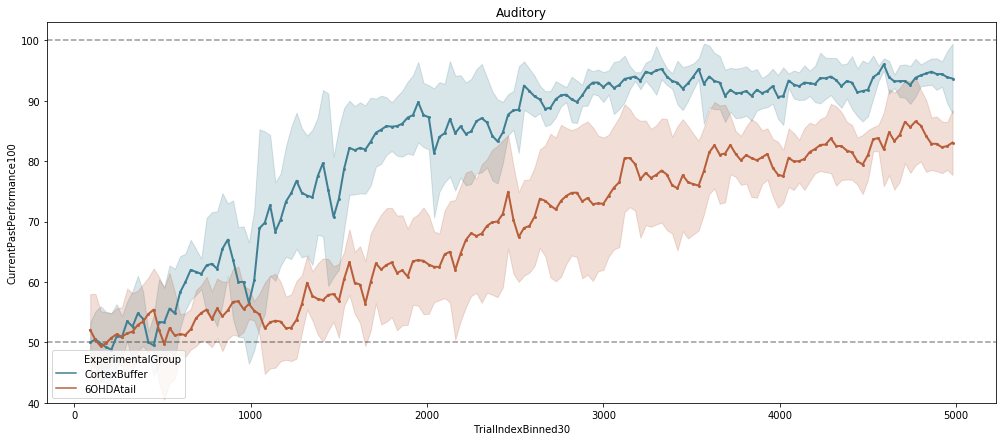

In [41]:
# plot the performance
column_to_plot = 'CurrentPastPerformance100'

fig, axs = plt.subplots(len(pd.unique(df_bintr['Protocol'])), 1, figsize=(17,7 * len(pd.unique(df_bintr['Protocol']))), sharex=True)
if axs.numRows > 1:
    axs = axs.ravel()
else:
    axs = [axs,]
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(df_bintr['Protocol'])):
    sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
                 data=df_bintr[df_bintr['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup',
                 hue_order=['CortexBuffer', '6OHDAtail'],
                 marker=".", alpha=1,
                 markeredgewidth=0, linewidth=2,
                 ci='sd')#, n_boot=10000)
                 # the following line splits the data and does not compute confidence intervals and mean
                 #units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=40)
    '''
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    '''
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
#plt.savefig(outputDir + column_to_plot + 'ByProtocol_Grouped_AnimalSelection.pdf',
plt.savefig(data_directory + column_to_plot + 'ByProtocol_Grouped.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

0.007898807525634766


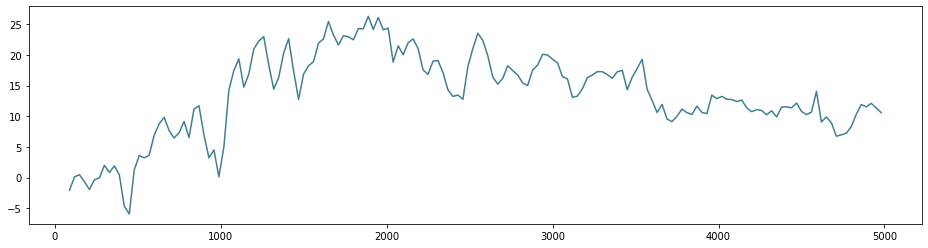

In [54]:
# plot the differences of the means
perdif_df = df_bintr[df_bintr.ExperimentalGroup == 'CortexBuffer'].groupby('TrialIndexBinned30').mean()[column_to_plot] -\
df_bintr[df_bintr.ExperimentalGroup == '6OHDAtail'].groupby('TrialIndexBinned30').mean()[column_to_plot]
plt.figure(figsize=(16, 4))
sns.lineplot(data=perdif_df)
plt.show()

##### Calculate the significance by resampling: suffle the group labels multiple times and calculate the likelyhood of observing this data
References:
Supplementary figure 4 in here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562676/

See also methods here: https://www.biorxiv.org/content/10.1101/716274v3.full

In [250]:
# define a function to generate a list of experimental groups randomly
def generate_eg(list_size, prob, labs = ['CortexBuffer', '6OHDAtail']):
    ltr = []
    for i in range(list_size):
        if random.random() < prob:
            ltr.append(labs[0])
        else:
            ltr.append(labs[1])
    return ltr

In [363]:
# specify the trial bining window
bw = 100
# bin trials every X and select the important columns
df_to_plot["TrialIndexBinned"] = (df_to_plot.CumulativeTrialNumberByProtocol // bw) * bw
df_colsel = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned','Protocol']).median().reset_index()[
    ['AnimalID', 'ExperimentalGroup', 'TrialIndexBinned', column_to_plot]
].copy()
# get the experimental group for each animal
exp_gr = [df_colsel[df_colsel.AnimalID==x].ExperimentalGroup.unique()[0] for x in df_colsel.AnimalID.unique()]
# get the number of mice
n_an = len(exp_gr)
# get the probability of a mouse to be a control for this dataset
cb_prob = sum([x=='CortexBuffer' for x in exp_gr]) / n_an
# set random seed
np.random.seed(124321)
# calculate the differences of means by resampling
shuff_res = []
nsh = 10000
for i in range(nsh):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.AnimalID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.AnimalID]
    # calculate the differences and append
    shuff_res.append(df_colsel[df_colsel.egs == 'CortexBuffer'].groupby('TrialIndexBinned').mean()[column_to_plot] -\
                     df_colsel[df_colsel.egs == '6OHDAtail'].groupby('TrialIndexBinned').mean()[column_to_plot])
    update_progress(i / nsh)
# save in a data frame format
shrdf = pd.concat(shuff_res)
update_progress(1)

Progress: [####################] 100.0%


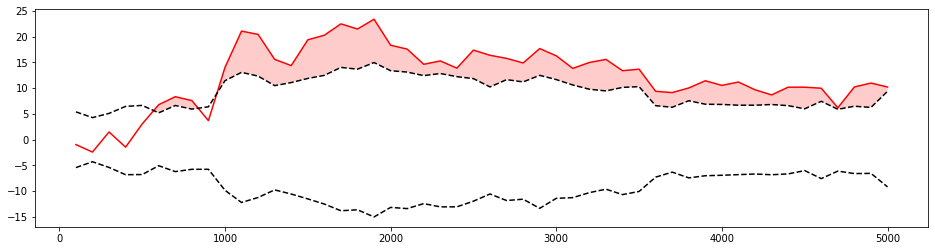

In [390]:
#plot
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

plt.figure(figsize=(16, 4))
plt.plot(real_data, color='r')
plt.plot(pos_ci, linestyle='--', color='k')
plt.plot(neg_ci, linestyle='--', color='k')
x = pos_ci.reset_index().TrialIndexBinned
y1 = pos_ci.reset_index().CurrentPastPerformance100
y2 = real_data.reset_index().CurrentPastPerformance100
plt.fill_between(x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.2, interpolate=True)

plt.savefig(data_directory + 'Significance_by_trial_Bin' + str(bw) + '.pdf',
            transparent=True, bbox_inches='tight')

plt.show()

###### Substitute of the mixed anova: find the likelihood of any point being significant. Shuffle more data and quantify the percentage of times there is a crossing. Generate global bands of confidence

In [368]:
quants_to_test = [0.99, 0.999, 0.9999]
nsh=1000
# create an empty array to store results
global_sig = np.empty((nsh, len(quants_to_test)), dtype=bool)
# loop over shuffle data
for i in range(nsh):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.AnimalID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.AnimalID]
    # calculate the differences
    sh_dif = df_colsel[df_colsel.egs == 'CortexBuffer'].groupby('TrialIndexBinned').mean()[column_to_plot] -\
                     df_colsel[df_colsel.egs == '6OHDAtail'].groupby('TrialIndexBinned').mean()[column_to_plot]
    # for each quantile band, what percentages of lines cross at any point
    for k,q in enumerate(quants_to_test):
        global_sig[i,k] = any(np.logical_or(sh_dif > shrdf.groupby('TrialIndexBinned').quantile(q),
                                            sh_dif < shrdf.groupby('TrialIndexBinned').quantile(1 - q)))
        
    update_progress(i / nsh)

Progress: [####################] 99.9%


ci =  0.99 	global pval =  0.235 	real data significant  True
ci =  0.999 	global pval =  0.033 	real data significant  True
ci =  0.9999 	global pval =  0.002 	real data significant  False
ci =  0.99999 	global pval =  0.002 	real data significant  False


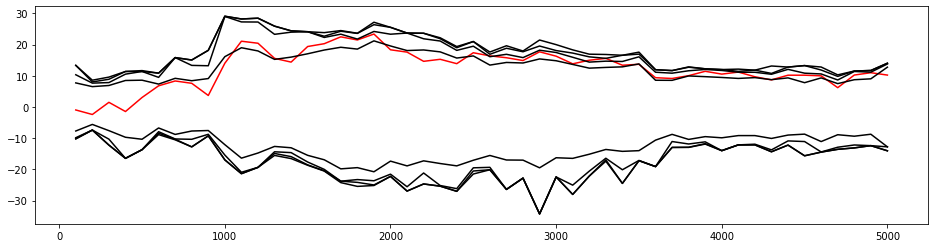

In [372]:
# plot the confidence intervals and print their global p-values:
real_data = df_colsel[df_colsel.ExperimentalGroup == 'CortexBuffer'].groupby('TrialIndexBinned').mean()[column_to_plot] -\
                     df_colsel[df_colsel.ExperimentalGroup == '6OHDAtail'].groupby('TrialIndexBinned').mean()[column_to_plot]
plt.figure(figsize=(16, 4))
sns.lineplot(data=real_data, color='r')
for k,q in enumerate(quants_to_test):
    sns.lineplot(data=shrdf.groupby('TrialIndexBinned').quantile(q), color='k')
    sns.lineplot(data=shrdf.groupby('TrialIndexBinned').quantile((1 - q)), color='k')
    print('ci = ', q,
          '\tglobal pval = ',  np.sum(global_sig, axis=0)[k] / nsh,
          '\treal data significant ', any(np.logical_or(real_data > shrdf.groupby('TrialIndexBinned').quantile(q),
                                            real_data < shrdf.groupby('TrialIndexBinned').quantile(1 - q))))
plt.show()

##### Perform a mixed anova to find if the two datasets differ globally

In [204]:
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200']).median().reset_index()[[
    'AnimalID','ExperimentalGroup','TrialIndexBinned200','CumulativePerformance','CurrentPastPerformance100']]

In [205]:
# transform trial bins to int
df_bin200tr.TrialIndexBinned200 = df_bin200tr.TrialIndexBinned200.astype(int)#.astype(str)

In [206]:
# remove the 5000 bin as is has one Nan
df_bin200tr = df_bin200tr[~ (df_bin200tr.TrialIndexBinned200 == 5000)]

In [207]:
df_bin200tr

,AnimalID,ExperimentalGroup,TrialIndexBinned200,CumulativePerformance,CurrentPastPerformance100
0,C01,CortexBuffer,0,51.523824,43.0
1,C01,CortexBuffer,200,47.142857,47.0
2,C01,CortexBuffer,400,47.247784,48.0
3,C01,CortexBuffer,600,48.947028,52.0
4,C01,CortexBuffer,800,60.269437,56.0
...,...,...,...,...,...
383,SomFlp09,6OHDAtail,4000,84.820335,83.0
384,SomFlp09,6OHDAtail,4200,85.348506,87.5
385,SomFlp09,6OHDAtail,4400,87.173814,85.0
386,SomFlp09,6OHDAtail,4600,87.228814,89.0


In [209]:
aov = pg.mixed_anova(dv='CurrentPastPerformance100', within='TrialIndexBinned200',
                     subject='AnimalID', between='ExperimentalGroup', data=df_bin200tr)
print(aov)

                Source         SS  DF1  DF2         MS       F          p-unc  \
0    ExperimentalGroup  12615.701    1   13  12615.701  19.594   6.834889e-04   
1  TrialIndexBinned200  58462.851   24  312   2435.952  78.450  6.389665e-117   
2          Interaction   3178.465   24  312    132.436   4.265   7.963433e-10   

     np2    eps  
0  0.601      -  
1  0.858  0.154  
2  0.247      -  


It is indeed significant

##### another way, less proper I think, to get to when the two groups differ, is to do multiple tests, and correct for multiple tests

In [ ]:
# another way is to DO THIS BY SESSION

KeyboardInterrupt: 

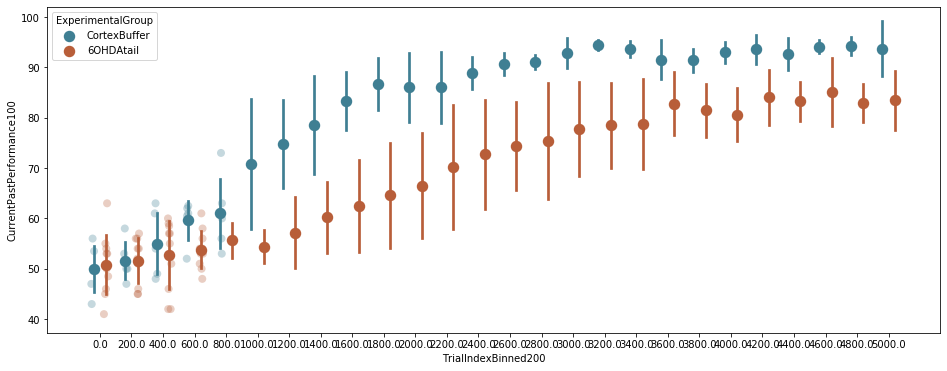

In [225]:
tr_to_show = [200, 600, 1000, 1400, 2000, 3000, 4000, 4800]
df_st = df_bin200tr[df_bin200tr.TrialIndexBinned200.isin(tr_to_show)]
df_st = df_bin200tr
plt.figure(figsize=(16, 6))

# add mean and sd
sns.pointplot(data=df_st,
              x='TrialIndexBinned200',
              y='CurrentPastPerformance100',
              hue='ExperimentalGroup',
              dodge=.4, join=False,
              markers="o", scale=1.3, ci='sd')

sns.stripplot(data=df_st,
            x='TrialIndexBinned200',
            y='CurrentPastPerformance100',
            hue='ExperimentalGroup',
            dodge=True, jitter=.15,
            alpha=.3, zorder=1, size=8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [272]:
# perform the tests
pvals = []
trial_bin = []
for index, group in df_st.groupby('TrialIndexBinned200'):
    kt = stats.kruskal(group[group.ExperimentalGroup=='CortexBuffer'].CurrentPastPerformance100,
              group[group.ExperimentalGroup=='6OHDAtail'].CurrentPastPerformance100)
    print('Trial: ' + str(index) + '\t\tpvalue: ' + str(kt.pvalue) )
    pvals.append(kt.pvalue)
    trial_bin.append(index)

Trial: 0		pvalue: 0.9510829486178052
Trial: 200		pvalue: 0.9021749986977411
Trial: 400		pvalue: 0.5395663432840505
Trial: 600		pvalue: 0.04273775685927219
Trial: 800		pvalue: 0.12273775154874209
Trial: 1000		pvalue: 0.03733641592066285
Trial: 1200		pvalue: 0.004773158857506389
Trial: 1400		pvalue: 0.005725749799250003
Trial: 1600		pvalue: 0.004810877118337757
Trial: 1800		pvalue: 0.004773158857506389
Trial: 2000		pvalue: 0.010045367654374767
Trial: 2200		pvalue: 0.03178204733588769
Trial: 2400		pvalue: 0.019964453305215894
Trial: 2600		pvalue: 0.002159698110595408
Trial: 2800		pvalue: 0.00997861827673295
Trial: 3000		pvalue: 0.006699196734067722
Trial: 3200		pvalue: 0.0021796154874983097
Trial: 3400		pvalue: 0.01189572924795044
Trial: 3600		pvalue: 0.019743775212009387
Trial: 3800		pvalue: 0.006699196734067722
Trial: 4000		pvalue: 0.005725749799250003
Trial: 4200		pvalue: 0.00839996382565715
Trial: 4400		pvalue: 0.0046239599622566446
Trial: 4600		pvalue: 0.02272571215415085
Trial: 4800

In [273]:
# perform the correction:
from statsmodels.stats.multitest import multipletests as mtpt
corrected_pvals = mtpt(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pvals

(array([False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 array([0.95108295, 0.93976562, 0.58648516, 0.05087828, 0.13947472,
        0.04667052, 0.01522545, 0.01522545, 0.01522545, 0.01522545,
        0.01793816, 0.04181848, 0.02935949, 0.01522545, 0.01793816,
        0.01522545, 0.01522545, 0.01982622, 0.02935949, 0.01522545,
        0.01522545, 0.01749992, 0.01522545, 0.03156349, 0.01522545]),
 0.0020496284126207964,
 0.002)

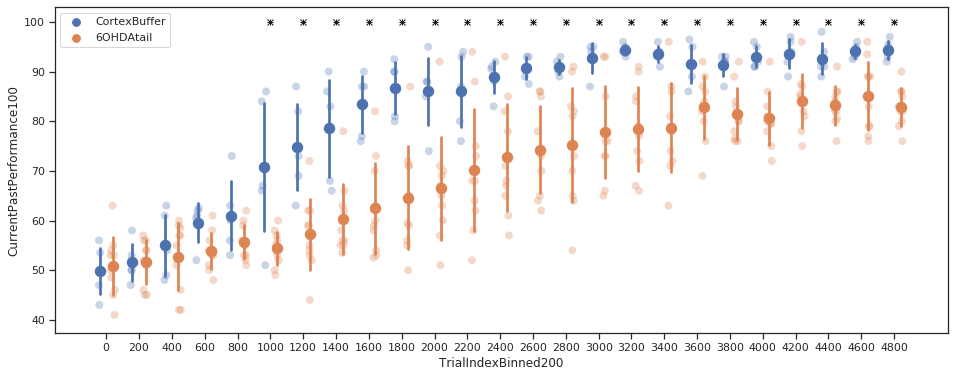

In [276]:
# redo the plot with the significance
plt.figure(figsize=(16, 6))

# add mean and sd
sns.pointplot(data=df_st,
              x='TrialIndexBinned200',
              y='CurrentPastPerformance100',
              hue='ExperimentalGroup',
              dodge=.4, join=False,
              markers="o", scale=1.3, ci='sd')

sns.stripplot(data=df_st,
            x='TrialIndexBinned200',
            y='CurrentPastPerformance100',
            hue='ExperimentalGroup',
            dodge=True, jitter=.15,
            alpha=.3, zorder=1, size=8)

# make stars for those significant
sig_x = np.transpose([i for i,x in enumerate(list(corrected_pvals[0])) if x])
y_points = np.transpose([100] * len(sig_x))
plt.gca().plot(sig_x, y_points, 'kx')
plt.gca().plot(sig_x, y_points, 'k+')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [60]:
dset = pd.DataFrame({'idx': np.repeat(np.arange(3), 100000), 'values': np.random.randn(300000), 'groups': np.arange(300000) % 2})
print(dset)
st = time.time()
dset.groupby('idx').apply(lambda x: x.loc[x.groups == 0, 'values'].mean() - x.loc[x.groups == 1, 'values'].mean())
print(time.time() - st)

        idx    values  groups
0         0  1.150299       0
1         0  0.404137       1
2         0 -0.137991       0
3         0 -1.111589       1
4         0 -0.631055       0
...     ...       ...     ...
299995    2 -0.766824       1
299996    2 -0.554615       0
299997    2 -0.366355       1
299998    2  0.788683       0
299999    2 -0.272992       1

[300000 rows x 3 columns]
0.022684335708618164


In [59]:
dset = pd.DataFrame({'idx': np.repeat(np.arange(3), 100000), 'values': np.random.randn(300000), 'groups': np.arange(300000) % 2})
print(dset)
st = time.time()
dset[dset.groups==0].groupby('idx').mean()['values'] - dset[dset.groups==1].groupby('idx').mean()['values']
#dset.groupby('idx').apply(lambda x: x.loc[x.groups == 0, 'values'].mean() - x.loc[x.groups == 1, 'values'].mean())
print(time.time() - st)

        idx    values  groups
0         0 -0.179495       0
1         0 -0.797644       1
2         0  0.437740       0
3         0  0.716834       1
4         0  0.148499       0
...     ...       ...     ...
299995    2 -0.854928       1
299996    2 -0.833598       0
299997    2  1.926245       1
299998    2  2.188073       0
299999    2 -1.287921       1

[300000 rows x 3 columns]
0.019878864288330078


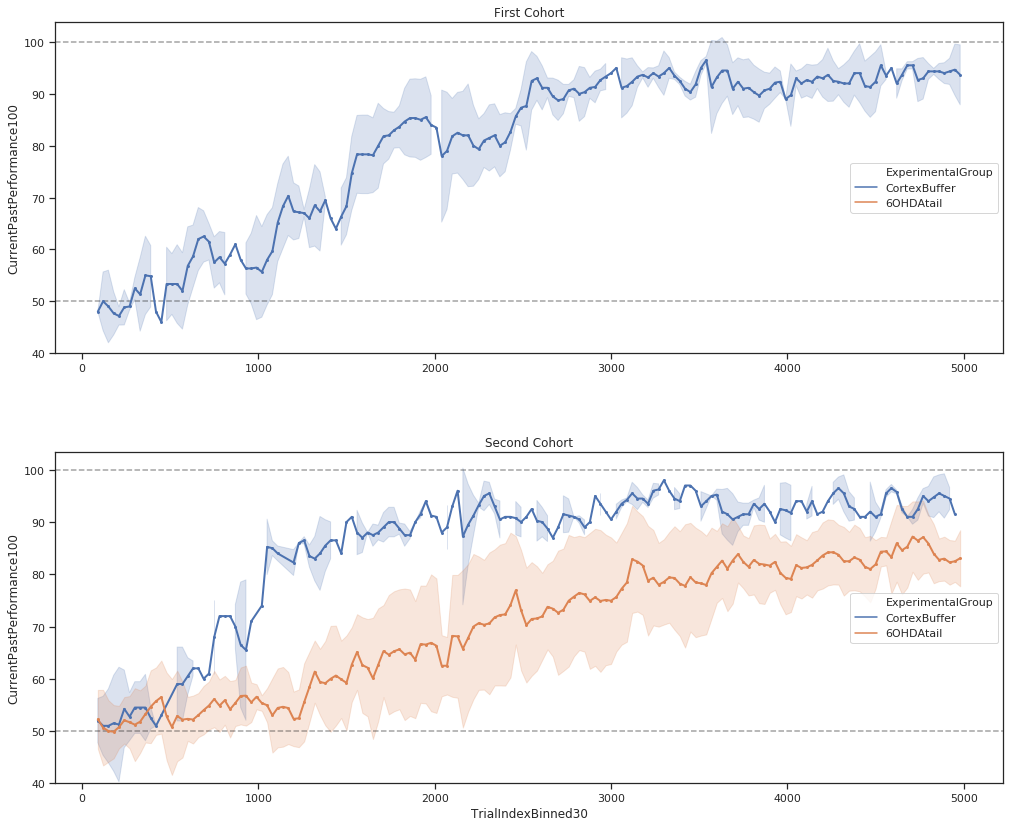

In [42]:
# test how this looks for each cohort
ans_in_first_cohort = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']

column_to_plot = 'CurrentPastPerformance100'

fig, axs = plt.subplots(2, 1, figsize=(17, 14), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
             data=df_bintr[df_bintr.AnimalID.isin(ans_in_first_cohort)],
             ax=axs[0], hue='ExperimentalGroup',
             hue_order=['CortexBuffer', '6OHDAtail'],
             marker=".", alpha=1,
             markeredgewidth=0, linewidth=2,
             ci='sd', n_boot=10000)
             
axs[0].set_title('First Cohort')
axs[0].set_ylim(bottom=40)

sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
             data=df_bintr[~df_bintr.AnimalID.isin(ans_in_first_cohort)],
             ax=axs[1], hue='ExperimentalGroup',
             hue_order=['CortexBuffer', '6OHDAtail'],
             marker=".", alpha=1,
             markeredgewidth=0, linewidth=2,
             ci='sd', n_boot=10000)
             
axs[1].set_title('Second Cohort')
axs[1].set_ylim(bottom=40)

for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

plt.show()

In [43]:
df_to_plot[df_to_plot.AnimalID=='C01'].dtypes

AnimalID                                   object
CenterPortDuration                        float64
Contingency                                 int64
CumulativePerformance                     float64
ExperimentalGroup                          object
FirstPoke                                 float64
FirstPokeCorrect                          float64
FullSessionTime                    datetime64[ns]
Muscimol                                   object
OptoStim                                  float64
Outcomes                                  float64
PreviousChoice                            float64
Protocol                                   object
ResponseTime                              float64
RewardAmount                                int64
RewardChange                               object
RewardChangeBlock                         float64
RightBias                                 float64
SessionTime                                object
Stimulation                                object


In [193]:
# Optional post-hoc tests
pg.pairwise_ttests(dv='CurrentPastPerformance100', between='ExperimentalGroup',
                   within='TrialIndexBinned200', subject='AnimalID', data=df_bin200tr,
                   alpha=0.05,
                   padjust='holm',
                   parametric=False)

TypeError: 'float' object is not iterable

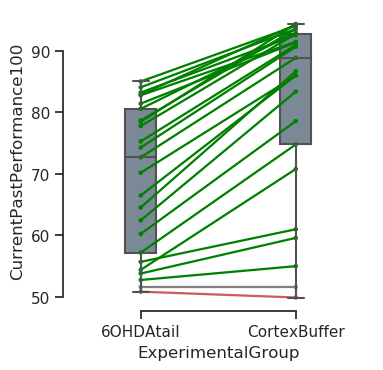

In [194]:
pg.plot_paired(dv='CurrentPastPerformance100', within='ExperimentalGroup',
                   subject='TrialIndexBinned200', data=df_bin200tr)